# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [2]:
import pandas as pd
from sqlalchemy import create_engine

sql_engine = create_engine("sqlite://", echo=False)
games_df = pd.read_csv("./input/games.csv")


In [3]:
def df_to_sql_table(sql_table_name: str, dataframe: pd.DataFrame) -> None:
    dataframe.to_sql(sql_table_name, sql_engine, if_exists="replace", index=False)
    print(
        f"""SQL table "{sql_table_name}" created/updated!

Please see below for a preview:"""
    )
    preview_sql_table(sql_table_name, sql_engine_name=sql_engine)


def preview_sql_table(
    sql_table_name: str,
    sql_engine_name,
    row_count=3,
) -> None:
    preview_sql_query = f"""SELECT * FROM {sql_table_name} LIMIT {row_count}"""
    display(pd.read_sql_query(preview_sql_query, sql_engine_name))


df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,tbd,tbd
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,tbd,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,tbd,4.0


## Cleaning


### Missing Values


#### `tbd` Metascore and user score are missing values

Metascore will be `tbd` if there are <4 reviews for that game. User score will be "tbd" if there are <7 reviews for that game.


In [4]:
import numpy as np

score_columns = [sc for sc in games_df.columns if sc.endswith("score")]
for c in score_columns:
    games_df[c] = games_df[c].replace("tbd", np.NaN)

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0


#### `summary`, `metascore` and `userscore` are difficult to impute

They are ignored for now, and will not be considered in analyses.


In [5]:
def count_missing_values(sql_table_name: str, col: str):
    count_missing_values_query = f"""
        SELECT SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) missing_values_count
        FROM {sql_table_name}
    """

    missing_count_df = pd.read_sql_query(count_missing_values_query, sql_engine)
    number_of_missing_values = int(missing_count_df.missing_values_count.iloc[0])
    print(f"""The column "{col}" has _{number_of_missing_values}_ missing values.""")
    if number_of_missing_values:
        show_missing_values_query = f"""
            SELECT *
            FROM {sql_table_name}
            WHERE {col} IS NULL
        """
        missing_values_df = pd.read_sql_query(show_missing_values_query, sql_engine)
        display(missing_values_df)
        return
    return


for c in games_df.columns:
    count_missing_values("games", c)


The column "name" has _0_ missing values.
The column "platform" has _0_ missing values.
The column "release_date" has _0_ missing values.
The column "summary" has _17715_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,100 Great Education Games Volume 4,PC,"May 10, 2002",None,None,None
1,1001 Jigsaw Cute Cats,PC,"August 3, 2022",None,None,None
2,1010! World,iOS,"July 6, 2015",None,None,None
3,18 Wheels of Steel: Hard Truck,PC,"March 18, 2021",None,None,None
4,1912 Titanic Mystery,PC,"July 17, 2019",None,None,5.3
...,...,...,...,...,...,...
17710,without Kungfu shut up,PC,"November 29, 2018",None,None,None
17711,work girl,PC,"November 22, 2019",None,None,None
17712,world of cubes,PC,"June 27, 2022",None,None,None
17713,xdding,PC,"December 23, 2022",None,None,None


The column "metascore" has _112155_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0
3,!4RC4N01D! 2: Retro Edition,PC,"February 6, 2018","Everyone dreams of returning 2007, but no one ...",None,3.8
4,!4RC4N01D! 3: Cold Space,PC,"March 8, 2018",!4RC4N01D! returns! This time we have an accid...,None,3.0
...,...,...,...,...,...,...
112150,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
112151,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
112152,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
112153,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


The column "userscore" has _105986_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,!Arre Unicornio!,PC,"March 18, 2022",Arre Unicornio! is an online multiplayer video...,None,None
2,"""Aha! I Found It!"" Hidden Object Game",Wii,"January 25, 2010",[WiiWare] A hidden-object game for everyone h...,None,None
3,"""Aha! I Got It!"" Escape Game",Wii,"November 2, 2009",[WiiWare] Play alone or with family and frien...,None,None
4,"""Burn your fat with me!!""",iOS,"September 25, 2012",“Burn your fat with me!!” is a fitness app/dat...,None,None
...,...,...,...,...,...,...
105981,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
105982,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
105983,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
105984,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


### Correct Data Types


In [6]:
for c in score_columns:
    games_df[c] = pd.to_numeric(games_df[c])

games_df["release_date"] = pd.to_datetime(games_df["release_date"], format="%B %d, %Y")
games_df["release_date"] = games_df["release_date"].dt.strftime("%Y-%m-%d")

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,2022-02-10,The year is 2119. A turning point has begun in...,None,NaN
1,! That Bastard Is Trying To Steal Our Gold !,PC,2014-05-11,It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,2018-01-12,Hardcore arkanoid in the spirit of old games f...,None,4.0


## Analysis


### Metascore vs User Scores

There are up to two scores (assuming sufficient rating volumes) for each game:

- A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
- A game's **user score** is the mean of users' scores.


#### Metascores and user scores have a **_low_**, **_positive_** correlation

The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

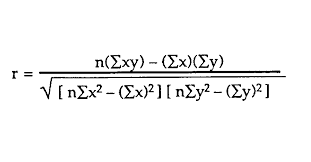


In [7]:
pd.read_sql_query(
    """
    SELECT AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) * AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((userscore - avg_userscore)*(userscore - avg_userscore)) as var_userscore,
                AVG((metascore - avg_metascore)*(metascore - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(userscore) AS avg_userscore,
                        AVG(metascore) AS avg_metascore
                    FROM games
                )
        )
    """,
    sql_engine,
)


,pearson_corr_coeff
0,0.215795


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.


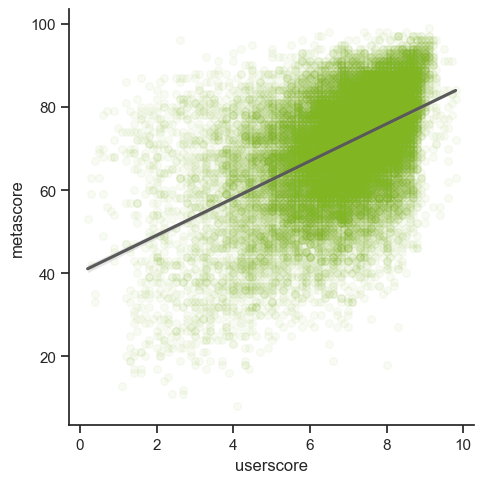

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=games_df,
    x="userscore",
    y="metascore",
    scatter_kws={"color": "#81B622", "alpha": 0.05, "s": 30},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms


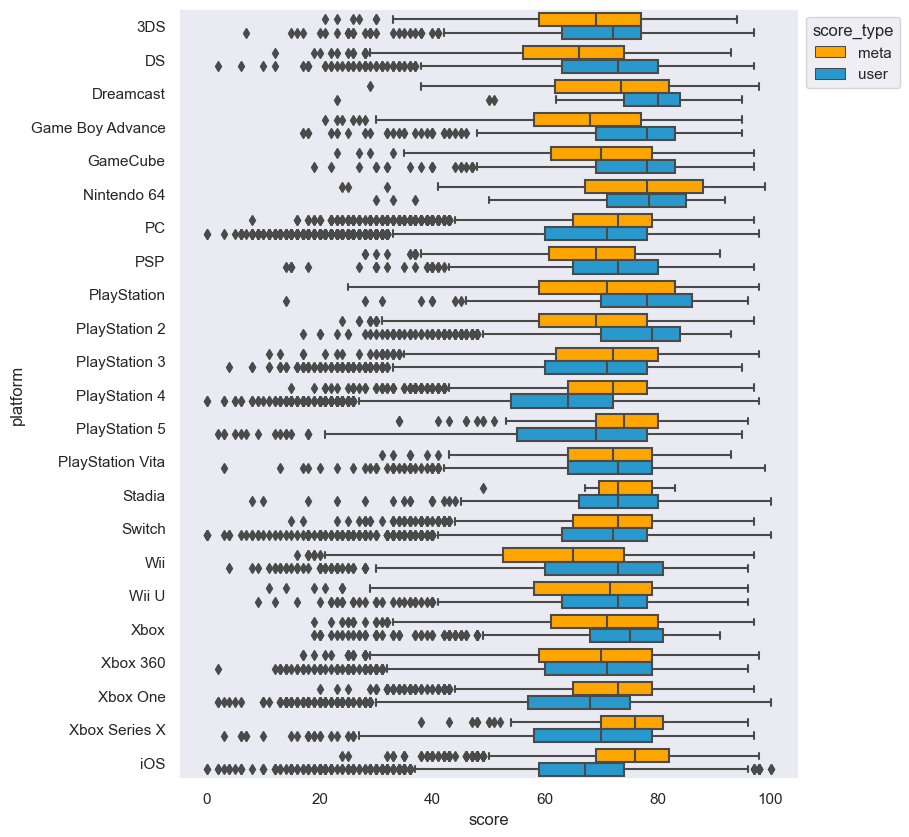

In [108]:
def boxplot_game_reviews(
    score_type_filter=["user", "meta"],
    platform_filter=False,
):
    sns.set(style="dark")
    scores_stacked_df = melt_table_by_score_type("games")
    data_df = scores_stacked_df[scores_stacked_df.score_type.isin(score_type_filter)]
    if platform_filter:
        data_df = data_df[data_df.platform.isin(platform_filter)]

    plt.figure(figsize=(8, 10))
    ax = sns.boxplot(
        data=data_df.sort_values(["platform", "score_type"]),
        x="score",
        y="platform",
        hue="score_type",
        orient="h",
        palette=["orange", "#2998cd"],
        saturation=1,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()


def melt_table_by_score_type(input_table: str) -> pd.DataFrame:
    melt_sql_query = f"""
        SELECT name,
            platform,
            metascore score, 
            'meta' score_type,
            STRFTIME('%Y-%m-%d', release_date) release_date
        FROM {input_table}
        WHERE score NOT NULL
        UNION ALL
        SELECT name,
            platform,
            userscore * 10 score,
            'user' score_type,
            STRFTIME('%Y-%m-%d', release_date) release_date
        FROM {input_table}
        WHERE score NOT NULL
    """
    res_df = pd.read_sql_query(melt_sql_query, sql_engine)
    return res_df


boxplot_game_reviews()


##### Users & Metacritics tend to agree that **Dreamcast** & **N64** have the best games...

As, by median score, these two platforms were in the top 5 for both Metascore and userscore score types.

- **N64** had the highest median Metascore (`78`), and 3rd in user score (`78.5`)
- **Dreamcast** had the highest median userscore (`80`), and 5th in Metascore (`73.5`)

The other platforms in the top 5s had less consistency across the score types. In particular:

- **iOS** had a much higher Metascore than user score, and
- **PS**, **PS2** and **GBA** had games that tend to be liked more by users than by Metacritics


_NB: as SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:_


In [205]:
def find_median_scores(group_by: str, sql_table=None, df=None) -> pd.DataFrame:
    scores_stacked_by_type_df = melt_table_by_score_type(sql_table) if sql_table else df
    res_df = (
        scores_stacked_by_type_df.groupby([group_by, "score_type"])
        .score.median()
        .reset_index()
        .rename(columns={"score": "median_score"})
    )
    df_to_sql_table(dataframe=res_df, sql_table_name="median_scores")
    return res_df


find_median_scores(sql_table="games", group_by="platform")


SQL table "median_scores" created/updated!

Please see below for a preview:


,platform,score_type,median_score
0,3DS,meta,69.0
1,3DS,user,72.0
2,DS,meta,66.0


,platform,score_type,median_score
0,3DS,meta,69.0
1,3DS,user,72.0
2,DS,meta,66.0
3,DS,user,73.0
4,Dreamcast,meta,73.5
5,Dreamcast,user,80.0
6,Game Boy Advance,meta,68.0
7,Game Boy Advance,user,78.0
8,GameCube,meta,70.0
9,GameCube,user,78.0


In [203]:
find_top5_query = """
    SELECT * FROM (
        SELECT 
            RANK() OVER (
                PARTITION BY score_type
                ORDER BY median_score DESC
            ) rank, 
            *
        FROM median_scores
    )
    WHERE rank <= 5
"""
top5_platforms_df = pd.read_sql_query(find_top5_query, sql_engine)
display(top5_platforms_df)


,rank,platform,score_type,median_score
0,1,Nintendo 64,meta,78.0
1,2,Xbox Series X,meta,76.0
2,2,iOS,meta,76.0
3,4,PlayStation 5,meta,74.0
4,5,Dreamcast,meta,73.5
5,1,Dreamcast,user,80.0
6,2,PlayStation 2,user,79.0
7,3,Nintendo 64,user,78.5
8,4,Game Boy Advance,user,78.0
9,4,GameCube,user,78.0


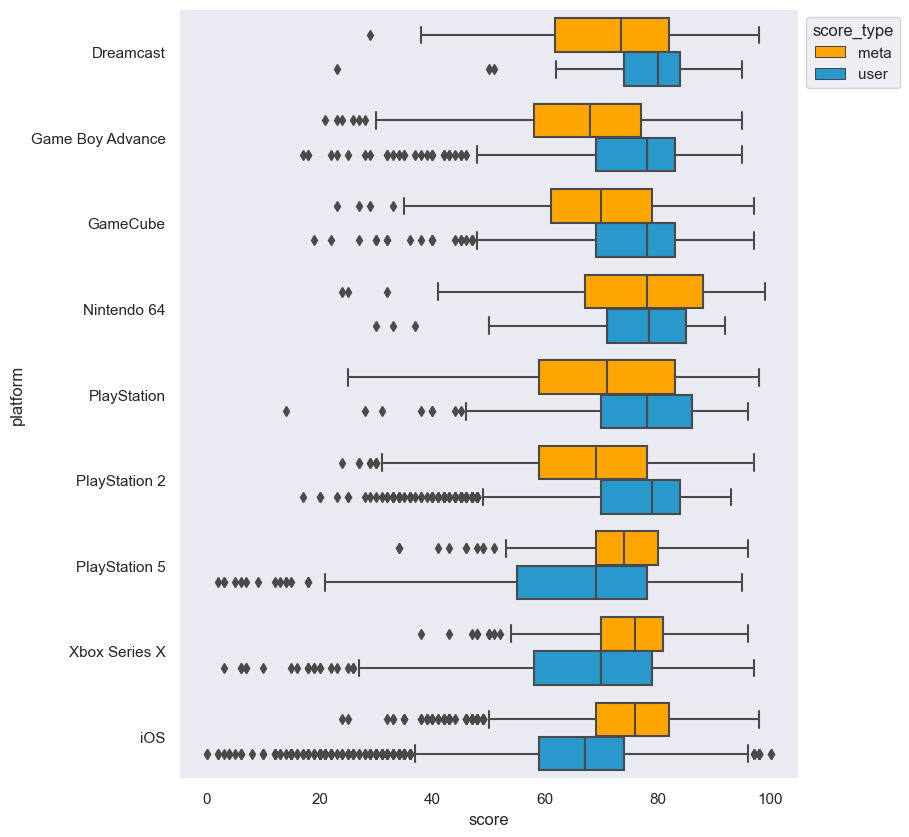

In [111]:
top5_platforms = set(top5_platforms_df.platform)
boxplot_game_reviews(platform_filter=top5_platforms)


#### We can be more confident about this finding as **Dreamcast** & **N64** have the least number of games with missing Metascores and/or user scores...

Recall earlier, I examined games that do not have a Metascore and/or user score due to insufficient reviews. Missing values are ignored in the above boxplots, which could introduce bias.

However,

- Every **Dreamcast** game on Metacritic has a Metascore. All but 6 have userscores.
- Every **N64** game on Metacritic has a userscore. All but 5 have a Metascore.

Contrastingly, **PC** games have an overwhelmingly high number of games that have no Metascores and/or userscores.


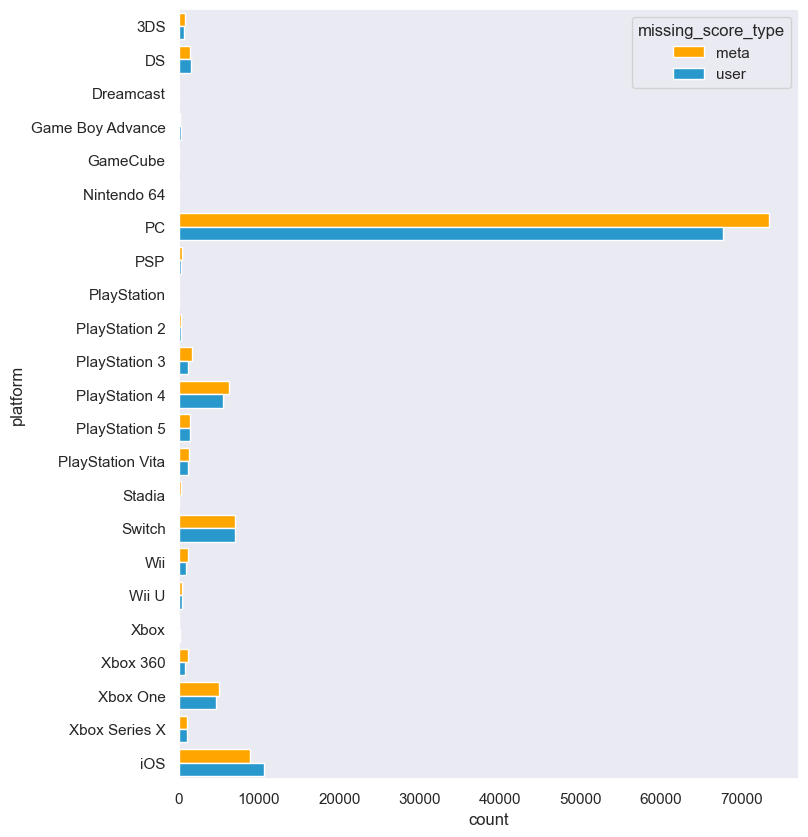

,platform,missing_metascores,missing_userscores
0,3DS,740,706
1,DS,1371,1537
2,Dreamcast,0,6
3,Game Boy Advance,172,257
4,GameCube,33,62
5,Nintendo 64,5,0
6,PC,73498,67752
7,PSP,420,314
8,PlayStation,33,57
9,PlayStation 2,298,278


In [164]:
def count_missing_scores_by_platform(sql_table_name: str) -> pd.DataFrame:
    sql_query = f"""
        WITH missing_metascore_count AS (
            SELECT 
                platform, 
                SUM(CASE WHEN metascore IS NULL THEN 1 ELSE 0 END) missing_metascores
            FROM {sql_table_name}
            GROUP BY 1
            ),
            
        missing_userscore_count AS (
            SELECT 
                platform, 
                SUM(CASE WHEN userscore IS NULL THEN 1 ELSE 0 END) missing_userscores
            FROM {sql_table_name}
            GROUP BY 1
        )
        
        SELECT 
            m.platform,
            m.missing_metascores,
            ROUND(u.missing_userscores) missing_userscores
        FROM missing_metascore_count m
        LEFT JOIN missing_userscore_count u
            USING (platform)
        UNION ALL
        SELECT
            m.missing_metascores,
            u.platform,
            ROUND(u.missing_userscores) missing_userscores
        FROM missing_userscore_count u
        LEFT JOIN missing_metascore_count m 
            USING (platform)
        WHERE u.platform IS NULL;
    """
    res_df = pd.read_sql_query(sql_query, sql_engine)
    numeric_columns = [c for c in res_df.columns if c.startswith("missing_")]
    for col in numeric_columns:
        res_df[col] = res_df[col].replace(np.NaN, 0).astype(int)
    return res_df


melted_missing_scores_df = pd.melt(
    count_missing_scores_by_platform("games"), id_vars=["platform"]
).rename(columns={"variable": "missing_score_type", "value": "count"})
melted_missing_scores_df.missing_score_type = (
    melted_missing_scores_df.missing_score_type.str.replace("missing_", "").str.replace(
        "scores", ""
    )
)

# melted_missing_scores_df
plt.figure(figsize=(8, 10))
ax = sns.barplot(
    y="platform",
    x="count",
    hue="missing_score_type",
    data=melted_missing_scores_df,
    orient="h",
    palette=["orange", "#2998cd"],
    saturation=1,
)
plt.show()
display(count_missing_scores_by_platform("games"))


#### Overall, users agree that **handheld** games are better

"Handheld" games have slightly lower Metascores, but the highest user scores.

"Mobile" games (**iOS**) attract some disagreement between Metacritics and users. Metacritics tend to rate iOS games the highest across all platform types. However, users tend to rate iOS games the lowest.

NB: For purposes of "handheld game console", I:

- excluded **iOS**: although smartphones capable of playing games, they are not generally classified as "video game consoles"
- included **Switch**: technically a hybrid capable of playing both as handheld and on TV. Switch Lite however is handheld only, but the games released on Switch and Switch Lite are capable of being played on both.


SQL table "scores_stacked" created/updated!

Please see below for a preview:


,name,platform,score,score_type,release_date
0,"""klocki""",iOS,83.0,meta,2016-07-13
1,#DRIVE,Switch,69.0,meta,2021-02-16
2,#IDARB,Xbox One,77.0,meta,2015-01-30


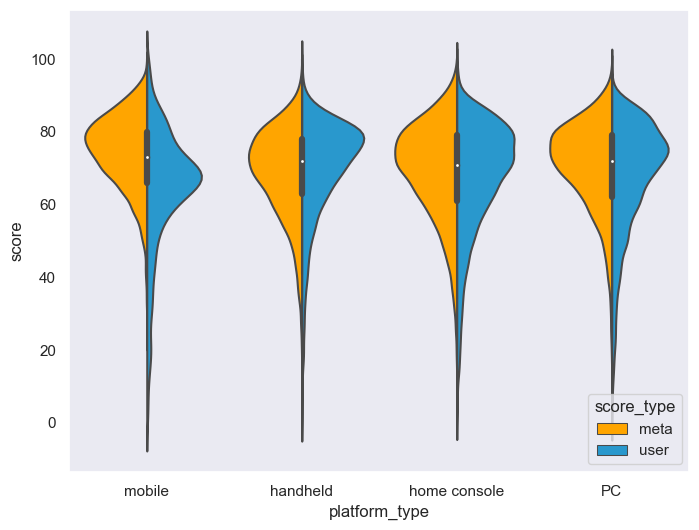

In [183]:
def classify_melted_table_by_platform_type(sql_table_name: str):
    scores_stacked_df = melt_table_by_score_type(sql_table_name)
    df_to_sql_table("scores_stacked", scores_stacked_df)

    HANDHELDS = ["3DS", "DS", "Game Boy Advance", "PSP", "PlayStation Vita", "Switch"]
    classify_platforms_query = f"""
        SELECT *,
        CASE
            WHEN platform IN {(*HANDHELDS,)} THEN 'handheld'
            WHEN platform IS 'PC' THEN 'PC'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
        FROM scores_stacked
    """
    platforms_classified_df = pd.read_sql_query(classify_platforms_query, sql_engine)

    return platforms_classified_df


def violinplot_handheld_vs_others(sql_table_name: str):
    plt.figure(figsize=(8, 6))
    ax = sns.violinplot(
        data=classify_melted_table_by_platform_type(sql_table_name),
        x="platform_type",
        y="score",
        hue="score_type",
        split=True,
        palette=["orange", "#2998cd"],
        saturation=1,
    )
    plt.show()


violinplot_handheld_vs_others("games")


### Games released in the mid-to-late '90s were liked by both Metacritics and users
* Games released in 1996-1999 have high median Metascores _and_ user scores
* Both median Metascores and user scores saw a sharp decline in 2000. However, **users liked games released in the 2000s more than Metacritics**
* Median Metascores and user scores have trended upwards for games released since 2014

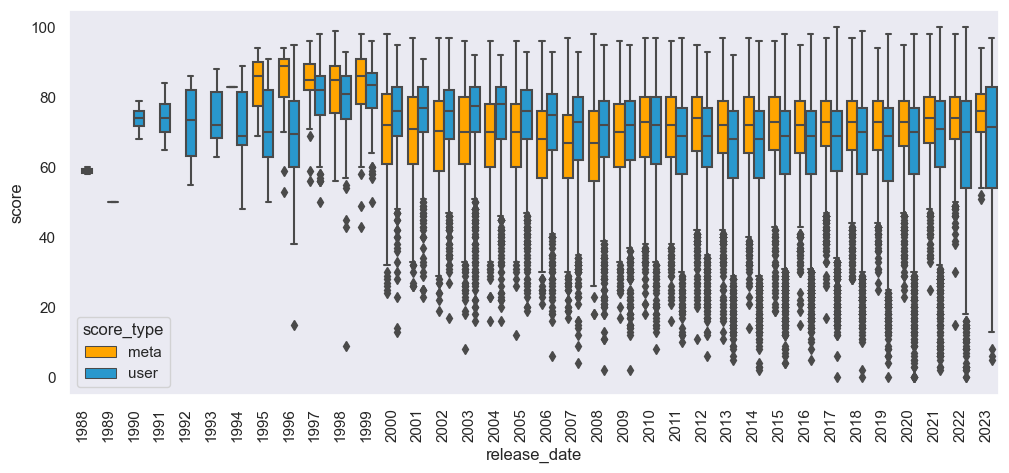

In [207]:
def stack_df_add_release_year(sql_table_name: str):
    scores_stacked_df = melt_table_by_score_type(sql_table_name)
    res_df = scores_stacked_df.copy()
    res_df["release_date"] = pd.to_datetime(res_df["release_date"], format="%Y-%m-%d")
    res_df["release_year"] = res_df["release_date"].dt.year
    return res_df


def boxplot_by_release_year(sql_table_name: str):
    data_df = stack_df_add_release_year("games")
    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(
        data=data_df,
        x=data_df["release_date"].dt.year,
        y="score",
        hue="score_type",
        palette=["orange", "#2998cd"],
        saturation=1,
    )
    plt.xticks(rotation=90)
    plt.show()
    return


boxplot_by_release_year("games")


SQL table "median_scores" created/updated!

Please see below for a preview:


,release_year,score_type,median_score
0,1988,user,59.0
1,1989,user,50.0
2,1990,user,74.0


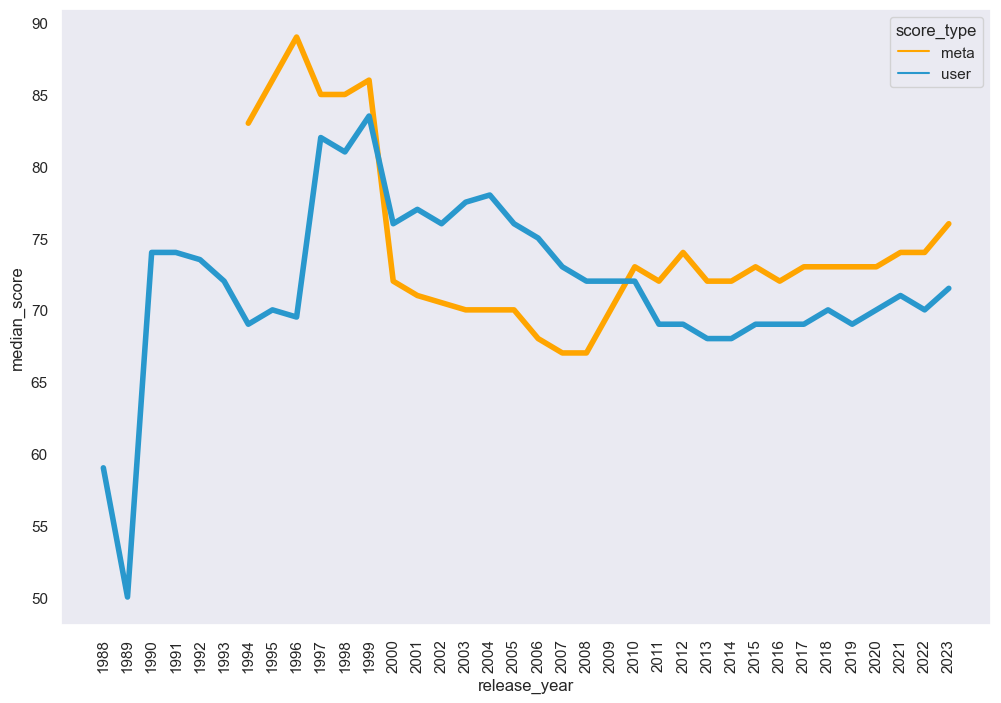

In [228]:
def lineplot_median_scores_over_time(sql_table_name: str):
    release_year_df = stack_df_add_release_year(sql_table_name)
    median_by_year_df = find_median_scores(group_by="release_year", df=release_year_df)
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(
        data=median_by_year_df.sort_values("score_type"),
        x="release_year",
        y="median_score",
        hue="score_type",
        palette=["orange", "#2998cd"],
        linewidth=4,
    )
    plt.xticks(
        range(
            median_by_year_df.release_year.min(),
            median_by_year_df.release_year.max() + 1,
        ),
        rotation=90,
    )
    plt.show()
    return


lineplot_median_scores_over_time("games")
